In [1]:
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.prebuilt import ToolNode
# These should already be installed on your workspace
!pip install --disable-pip-version-check --quiet -U langchain==0.2.16
!pip install --disable-pip-version-check --quiet -U langchain_openai==0.1.23
!pip install --disable-pip-version-check --quiet -U langgraph==0.2.19
!pip install --disable-pip-version-check --quiet -U langchainhub==0.1.21
!pip install --disable-pip-version-check --quiet -U tavily-python==0.4.0
!pip install --disable-pip-version-check --quiet -U langchain-community==0.2.16
!pip install --disable-pip-version-check --quiet -U python-dotenv==1.0.1

In [2]:
# Load in the OpenAI key and Tavily key.
# In the project folder, create a file named 'config.env'
# ensure your config.env file contains keys named OPENAI_API_KEY="your key" and TAVILY_API_KEY="your key"
from dotenv import load_dotenv
import os 

load_dotenv('config.env')
assert os.getenv('OPENAI_API_KEY') is not None
assert os.getenv('TAVILY_API_KEY') is not None

In [10]:
from tavily import TavilyClient
from langchain_core.tools import tool
import time
from langgraph.graph import MessagesState, START, StateGraph, END
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from IPython.display import Image, display

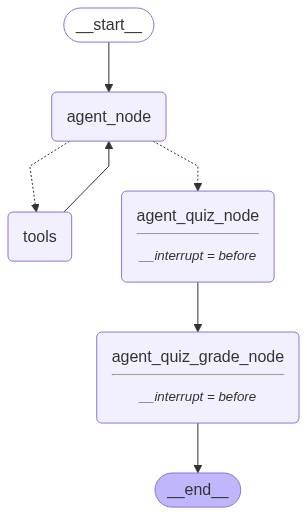

In [11]:

from langchain_core.messages import ToolMessage
from typing import Dict

import uuid

# Helper functions
def display_text_to_user(text):
    print(("=" * 50) + "\n")
    print(text)
    time.sleep(1) # wait for it to render before asking for input or it'll never show up.

def ask_user_for_input(input_description):
    response = input(input_description)
    return response

@tool
def web_search(question: str) -> Dict:
    """
    Return top search results for a given search query
    """
    tc = TavilyClient(api_key=os.getenv('TAVILY_API_KEY'))
    # Generated
    reputable_medical_domains = [
        "nih.gov", "cdc.gov", "who.int", "mayoclinic.org",
        "pubmed.ncbi.nlm.nih.gov", "diabetes.org"
    ]
    response = tc.search(question, include_domains=reputable_medical_domains)
    result = "\n".join(str(item['content']) for item in response['results'])
    return result

class State(MessagesState):
    user_question: str
    quiz_answer: str
    quiz_question: str
    user_question_answer_summary: str

model = ChatOpenAI(base_url = "https://openai.vocareum.com/v1", model="gpt-4o", temperature=0, streaming=True)
tools = [web_search]
model_with_tools = model.bind_tools(tools)
workflow = StateGraph(State)

# nodes
def should_use_tool_or_end(state: State) -> str:
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return 'agent_quiz_node'


def agent_quiz_node(state: State):
    summary_text = state['user_question_answer_summary']
    system_prompt_content = (
        "You are an expert Quiz Question Crafter. Your task is to generate one clear and "
        "concise quiz question based exclusively on the information presented in the provided summary. "
        "The question MUST be answerable using only the information found within the summary and can be evaluated with a grade scale 'A', 'B' or 'C'.")

    user_prompt_template = f"""
        Here is the summary:
        ---
        {summary_text}
        ---
        Based on this summary, please provide only the quiz question.
        """

    messages_for_quiz = [
        SystemMessage(system_prompt_content),
        HumanMessage(user_prompt_template)
    ]
    ai_message = model_with_tools.invoke(messages_for_quiz)
    return {'messages': [ai_message], 'quiz_question': ai_message.content}

def agent_quiz_grade_node(state: State):
    summary_text = state['user_question_answer_summary']
    quiz_answer = state['quiz_answer']
    system_prompt_content = (
        "You are an expert Quiz Question Evaluator. Your task is evaluate the quiz based on the question provided. You should evaluate the quiz answer based exclusively on the information presented in the provided summary and grade it on the following scale; 'A', 'B' or 'C'. Also, justify your evaluation with a sentence which means why did you grade it in that way."
        "Do NOT use any external knowledge.")

    user_prompt_template = f"""
        Here is the summary:
        ---
        {summary_text}
        ---
        Here is the quiz answer:
        ---
        {quiz_answer}
        ---
        [YOUR JUSTIFICATION]
        """

    messages_for_quiz_result = [
        SystemMessage(system_prompt_content),
        HumanMessage(user_prompt_template)
    ]
    ai_message = model_with_tools.invoke(messages_for_quiz_result)
    return {'messages': [ai_message]}

def agent_node(state: State):
    question = state['user_question']
    state_messages = state['messages']
    if not state_messages:
        system_message = SystemMessage(content="You conduct web search to respond to user's questions as long as they are related to health topic or medical condition. Otherwise, inform the user that you can't assist them. Besides, summarize web search results in three to four paragraphs in a patient friendly way")
        state_messages.append(system_message)

        human_message = HumanMessage(question)
        state_messages.append(human_message)

    ai_message = model_with_tools.invoke(state_messages)

    return {'messages': [ai_message]}


workflow.add_node("tools", ToolNode(tools))
workflow.add_node("agent_quiz_node", agent_quiz_node)
workflow.add_node("agent_node", agent_node)
workflow.add_node("agent_quiz_grade_node", agent_quiz_grade_node)

workflow.add_edge(START, "agent_node")
workflow.add_edge("tools", "agent_node")
workflow.add_edge("agent_quiz_node", "agent_quiz_grade_node")
workflow.add_edge("agent_quiz_grade_node", END)


workflow.add_conditional_edges(
    source="agent_node",
    path=should_use_tool_or_end,
    path_map={
        "tools": "tools",
        "agent_quiz_node": "agent_quiz_node",
    },
)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory, interrupt_before=['agent_quiz_node', 'agent_quiz_grade_node'])
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
from langgraph.graph.state import CompiledStateGraph

def patient_in_the_loop_run(graph: CompiledStateGraph, current_config: RunnableConfig):
    user_input_question = ask_user_for_input("What type of medical condition or health topic would you like to know about?")
    input_question = { "user_question": user_input_question.strip() }
    tool_message = ''

    current_state = graph.invoke(input=input_question, config=current_config)
    if current_state.get('messages'):
        for i, msg in enumerate(current_state.get('messages')):
            if isinstance(msg, ToolMessage):
                tool_message = msg.content
        display_text_to_user(current_state.get('messages')[-1].content)

    graph.update_state(
            config=current_config,
            values={"user_question_answer_summary": tool_message})

    user_input = ask_user_for_input("Are you ready to take a comprehension check? Please type 'yes' or 'no'")
    if user_input.strip().lower() == "yes":
        current_state = graph.invoke(input=None, config=current_config)
        question = ''
        if current_state.get('messages'):
            question = current_state.get('messages')[-1].content
            display_text_to_user(question)

        user_quiz_answer_input = ask_user_for_input("Please provide your answer. " + question)
        graph.update_state(
            config=current_config,
            values={"quiz_answer": user_quiz_answer_input.strip()},
            as_node="agent_quiz_node")

        current_state = graph.invoke(input=None, config=current_config)
        if current_state.get('messages'):
            display_text_to_user(current_state.get('messages')[-1].content)

while True:
    config = RunnableConfig(recursion_limit=2000, configurable={"thread_id": str(uuid.uuid4())})
    patient_in_the_loop_run(graph=app, current_config=config)

    continue_session = ask_user_for_input(
            "Would you like to start with a new medical topic?  Please type 'yes' or 'no'"
        ).strip().lower()
    if continue_session != "yes":
        print("Thank you for using the HealthBot")
        break

    print("\n===================================")
    print("Okay, let's start a new topic!")
    print("===================================\n")



Blood type compatibility is an important concept in medicine, particularly when it comes to blood transfusions, organ transplants, and pregnancy. The ABO blood group system and the Rh factor are the primary determinants of blood type compatibility. The ABO system classifies blood into four main types: A, B, AB, and O, based on the presence or absence of antigens on the surface of red blood cells. The Rh factor further categorizes blood as either positive or negative, depending on the presence of the Rh antigen.

In terms of compatibility, individuals with type O negative blood are considered universal donors for red blood cells, as their blood lacks A, B, and Rh antigens, minimizing the risk of an immune reaction. Conversely, individuals with type AB positive blood are universal recipients, as they can receive red blood cells from any ABO or Rh type without risk of incompatibility. However, for plasma transfusions, the compatibility is reversed: AB is the universal donor, and O is the

KeyboardInterrupt: Interrupted by user